# Load and View the Dataset

In [1]:
from scripts.dataset_utils import convert_to_rft_countdown_training_dataset
from datasets import load_dataset
from dotenv import load_dotenv
import json

# Load environment variables from the .env file
load_dotenv(override=True)

def convert_to_eval_format_separate_fields(input_file_path, output_file_path):
    """
    Convert a JSONL file to a specific evaluation format by adding an enclosing item field.

    Args:
        input_file_path: The path to the input JSONL file.
        output_file_path: The path to the output JSONL file.
    """
    with open(input_file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    with open(output_file_path, "w", encoding="utf-8") as f:
        for line in lines:
            example = json.loads(line)
            # Add the enclosing item field
            formatted_example = {"item": example}
            f.write(json.dumps(formatted_example) + "\n")
    print(f"✅ Converted {input_file_path} to {output_file_path}")


def save_dataset_as_jsonl(dataset, file_path, max_records=None):
    """
    Save a dataset to a JSONL file with all values converted to strings.

    Args:
        dataset: The dataset to save.
        file_path: The path to the output JSONL file.
        max_records: The maximum number of records to save (optional).
    """
    if max_records:
        dataset = dataset.shuffle(seed=123).select(range(max_records))
    
    with open(file_path, "w", encoding="utf-8") as f:
        for example in dataset:
            # Convert all values in the example to strings
            stringified_example = {key: str(value) for key, value in example.items()}
            f.write(json.dumps(stringified_example) + "\n")
    print(f"✅ Saved {len(dataset)} records to {file_path}")

# Load the SHP dataset
dataset = load_dataset("predibase/countdown", split="train")
eval_dataset = load_dataset("predibase/countdown", split="test")

train_file_path = "data/countdown/countdown_train_set.jsonl"
eval_file_path = "data/countdown/countdown_eval_set.jsonl"

# Save the datasets
save_dataset_as_jsonl(eval_dataset, eval_file_path)
save_dataset_as_jsonl(dataset,train_file_path, max_records=1000)

eval_file_path = "data/countdown/countdown_eval_set.jsonl"
eval_format_file_path = "data/countdown/countdown_eval_set_format.jsonl"
rft_format_file_path = "data/countdown/countdown_train_set_format.jsonl"

# convert to eval format i.e. add a enclosing item field to every example in jsonl
convert_to_eval_format_separate_fields(eval_file_path, eval_format_file_path)

convert_to_rft_countdown_training_dataset(input_path=train_file_path, output_path=rft_format_file_path, max_records=10)




c:\Users\omkarm\AppData\Local\anaconda3\envs\openai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Saved 500 records to data/countdown/countdown_eval_set.jsonl
✅ Saved 1000 records to data/countdown/countdown_train_set.jsonl
✅ Converted data/countdown/countdown_eval_set.jsonl to data/countdown/countdown_eval_set_format.jsonl
✅ Converted 10 records to RFT format and saved to data/countdown/countdown_train_set_format.jsonl


# Evaluate Base Model - o3

In [2]:
from scripts.io_utils import upload_file



# eval_file_id = "file-2d7554dc2266432ea9d8a8483ead1117"
eval_file_id = await upload_file(file_name="countdown_eval_set_format.jsonl", file_path=eval_format_file_path, purpose="evals")
print(f"Eval file ID: {eval_file_id}")


Using Azure API for file upload...


File uploaded successfully to Azure.
Eval file ID: file-d648930a261e493eaa86818b61677de8


In [4]:
# Create a new evaluation

from scripts.eval_utils import create_eval

# Call the create_eval function
eval_id = await create_eval("puzzle_base_eval_202-grader-4_1", grader_model="gpt-4.1", pass_threshold=4)

# eval_id = "eval_681fca42e0148190af03fecfd662e5d6"

print(f"Evaluation created with ID: {eval_id}")


Evaluation created successfully with ID: eval_6823f7877bd88190bc768ca70a878596
Evaluation created with ID: eval_6823f7877bd88190bc768ca70a878596


In [5]:
# Import the create_eval_run function from the eval_utils script
from scripts.eval_utils import create_eval_run


# Set your Model Deployment Names for the run
RUN_MODEL_DEPLOYMENTS = [
    # "o3",
    # "o4-mini",
    # "o3-mini",
    # "gpt-4o",
    # "gpt-4o-mini",
    # "gpt-4.1",
    # "gpt-4.1-mini",
    # "ft-o3-mini-puzzle",
    "ft-o3-mini-puzzle-300",
    # "o3-mini-2025-01-31-puzzles-train-10-val-10-rft"

]

# eval_file_id = "file-97ccc7b1f9024ba7b061130299152160"
# eval_id = "eval_682318c1171c819093f6ad19501a4bff"

# Create Eval Runs for each deployment
for deployment in RUN_MODEL_DEPLOYMENTS:
    await create_eval_run(eval_id, eval_file_id, deployment)

# Print the evaluation ID
print(f"Evaluation ID: {eval_id}")

Create Eval Run Status for ft-o3-mini-puzzle-300: 201
Evaluation ID: eval_6823f7877bd88190bc768ca70a878596


Get Evaluation Runs: eval_6824042ebe388190951374518e6380c4

Combined Evaluation Summary
                                  Run ID     Run Name        Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID Evaluation Name
evalrun_6824042ff4d48190a948ea5a2c8ab48b           o3           o3 completed           90.380762                  0.2 eval_6824042ebe388190951374518e6380c4  countdown eval
evalrun_682404d46c2881908266397d3c64fccb      o4-mini      o4-mini completed           89.200000                  0.0 eval_6824042ebe388190951374518e6380c4  countdown eval
evalrun_682404bb15108190a0ffa8030798f095      gpt-4.1      gpt-4.1 completed           31.000000                  0.0 eval_6824042ebe388190951374518e6380c4  countdown eval
evalrun_6824050aa4b08190854b09b95910a194 gpt-4.1-mini gpt-4.1-mini completed           25.400000                  0.0 eval_6824042ebe388190951374518e6380c4  countdown eval


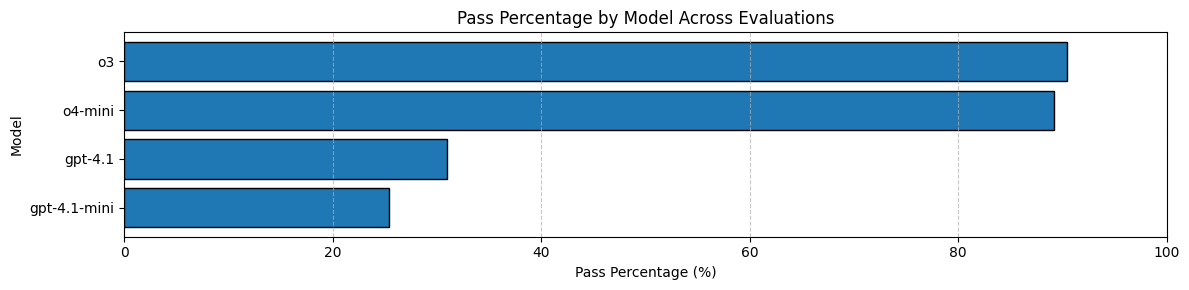

In [1]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary, display_evaluation_details

# eval_id = "eval_68230245f9dc81908eedaf94a0c6b753" # azure
eval_id = "eval_6824042ebe388190951374518e6380c4" # openai
# Display the evaluation summary
await display_evaluation_summary([eval_id])

In [3]:
from scripts.eval_utils import display_evaluation_details

eval_id = "eval_6824042ebe388190951374518e6380c4"
eval_run_id = "evalrun_682404d46c2881908266397d3c64fccb"
await display_evaluation_details(eval_id=eval_id, eval_run_id=eval_run_id, max_records=100, status_filter="fail")


Evaluation Details for Run ID: evalrun_682404d46c2881908266397d3c64fccb

Sample 1:
--------------------------------------------------
Reference Final Answer: N/A
Output Final Answer: N/A
Score: 4.0
Status: fail
--------------------------------------------------

Sample 2:
--------------------------------------------------
Reference Final Answer: N/A
Output Final Answer: N/A
Score: 4.0
Status: fail
--------------------------------------------------

Sample 3:
--------------------------------------------------
Reference Final Answer: N/A
Output Final Answer: N/A
Score: 4.0
Status: fail
--------------------------------------------------

Sample 4:
--------------------------------------------------
Reference Final Answer: N/A
Output Final Answer: N/A
Score: 4.0
Status: fail
--------------------------------------------------

Sample 5:
--------------------------------------------------
Reference Final Answer: N/A
Output Final Answer: N/A
Score: 4.0
Status: fail
----------------------------

In [ ]:
from scripts.dataset_utils import convert_rft_to_sft

# Convert the evaluation results to SFT format
rft_file_path = "data/Hydrobonds_Original_WoSysPromptInUser/train_900.jsonl"
sft_file_path = "data/Hydrobonds_Original_WoSysPromptInUser/train_900_sft.jsonl"
convert_rft_to_sft(rft_file_path, sft_file_path)

TypeError: convert_rft_to_sft() got an unexpected keyword argument 'status_filter'